In [1]:
# Needs OpenCV (Computer Vision) for image processing
# Needs ipympl for making matplotlib talk nicely with the widgets
# pip install opencv-python
# pip install ipympl

In [24]:
# Import the libraries
%matplotlib widget
import pandas as pd
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.font_manager as fm
plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
max_length = 200  # Defines the number of frames to read over

In [5]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# this is where you put in the filepath to where your video is: <----------------- IMPORTANT
fname = "io/inputs/video/dpo_14.mp4"

cap = cv2.VideoCapture(fname)
    # Name of video file.
    
img_list = []
for i in range(0,max_length):
    ret, img = cap.read()
    if (not ret):
        print("End of file reached!")
        raise StopExecution # gracefully shuts down when end of file is reached
    img_list.append(img)

End of file reached!


In [46]:
fname_ruler = "io/inputs/video/dpo_14_r.mp4"

cap = cv2.VideoCapture(fname_ruler)
    # Name of video file.
    
img_list_ruler = []
for i in range(0, max_length):
    ret, img_ruler = cap.read()
    if (not ret):
        print("End of file reached!")
        raise StopExecution # gracefully shuts down when end of file is reached
    img_list_ruler.append(img_ruler)
    


In [6]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual,Layout
import ipywidgets as widgets
plt.ioff() #prevents us from drawing extra plots while setting up

#These can all be changed fairly safely
target_size = 10 #size of zoom area.  Most useful thing to change if you need to see more.
tval = 180
bval = 10
xval = 100
brightness = 1.0
frame = 0

#Do not mess with
xdim = len(img_list[0][0])-1
ydim = len(img_list[0])-1


#This establishes all the widgets used for controls and display
y_slider = widgets.FloatRangeSlider(min=0,max=ydim,step=1,orientation='vertical',description='width',layout=Layout(height='300px'))
x_slider = widgets.IntSlider(min=0,max=xdim,description='length',layout=Layout(width='100%'))
bri_slider = widgets.FloatSlider(min=1,max=10,orientation='vertical',description='brightness')
frame_slider = widgets.IntSlider(min=0,max=ydim,orientation='vertical',description='frame')
record_button = widgets.Button(description='save')
record_next_button = widgets.Button(description='save & advance')
drop_disp = widgets.Output(layout=Layout(width='40%'))
neck_disp = widgets.Output(layout=Layout(width='50%'))


# Now we set up our image of the drop
fig = plt.figure(figsize=(7,3),constrained_layout=True)
gs = fig.add_gridspec(2,8) # gs stands for 'grid spec', and gives better control over the relative size of subplots

ax = fig.add_subplot(gs[0:2,0:-2])
drop_img = ax.imshow(np.clip(brightness*img_list[0]/100., 0, 1),origin='lower') #show the image
ax.set_yticks(np.linspace(0,len(img_list[0]),5))
drop_meas = ax.vlines(xval,tval,bval,color='red') #show a measurement line
minx,maxx = plt.gca().get_xlim() #Fix for zooming in
miny,maxy = plt.gca().get_ylim()
    
#This sets up zoomed-in areas for better visualization
ax_top = fig.add_subplot(gs[0, -2:])
ax_top.yaxis.tick_right()
drop_img_t = ax_top.imshow(np.clip(brightness*img_list[0]/100., 0, 1),origin='lower')
drop_meas_t = ax_top.vlines(xval,tval,bval,color='red',linewidth=3)

ax_bot = fig.add_subplot(gs[1, -2:])
ax_bot.yaxis.tick_right()
drop_img_b = ax_bot.imshow(np.clip(brightness*img_list[0]/100., 0, 1),origin='lower')
drop_meas_b = ax_bot.vlines(xval,tval,bval,color='red',linewidth=3)

#Extra code to center our zoomed plots on the ends of our measuring line
def set_xlims(ax_target,x,ts=target_size,xdim=xdim):
    if x < ts:
        ax_target.set_xlim(0, 2*ts)
    elif x > xdim-ts:
        ax_target.set_xlim(xdim-(2*ts),xdim)
    else:
        ax_target.set_xlim(x-ts,x+ts)

def set_ylims(ax_target,y,ts=target_size,ydim=ydim):
    if y < ts:
        ax_target.set_ylim(0, 2*ts)
    elif y > ydim-ts:
        ax_target.set_ylim(ydim-(2*ts),ydim)
    else:
        ax_target.set_ylim(y-ts,y+ts)

set_xlims(ax_top,xval)
set_xlims(ax_bot,xval)
set_ylims(ax_top,tval)
set_ylims(ax_bot,bval)


# This part will create a plot of our neck radius versus frame as we go
fig2,ax2 = plt.subplots(figsize = (4,2),dpi=100)
fig2.canvas.toolbar_visible = False
fig2.canvas.header_visible = False
ax2.set_title("Radius vs frame")
neck_img, = ax2.plot([0],[0],'k.-')
ax2.autoscale_view()

# Zero out any existing measurements when resetting
measurements = [[]]

# Make sure our sliders match up with our initial settings
y_slider.value = [bval,tval] #Not a bug, the slider just works this way.
x_slider.value = xval
bri_slider.value = brightness
frame_slider.value = frame


# The following functions all tie into sliders/buttons and pass their values onto the plot to update it
def y_change(change): 
    global tval,bval
    tval = change['new'][1] #this makes the directions behave as you'd expect
    bval = change['new'][0]
    newshowframe(tval,bval,xval,brightness,frame)
    
def x_change(change): 
    global xval
    xval = change['new']
    newshowframe(tval,bval,xval,brightness,frame)
        
def brightness_change(change): 
    global brightness
    brightness = change['new']
    newshowframe(tval,bval,xval,brightness,frame)
    
def frame_change(change): 
    global frame
    frame = change['new']
    newshowframe(tval,bval,xval,brightness,frame)
    
def record(value): 
    global measurements
    global frame,tval,bval,xval
    try:  # This will be what normally happens: we just add our data onto the end of a list
        measurements = np.append(measurements,[[frame,abs(tval-bval),bval,tval,xval]],axis=0)
    except: # This happens at the first time we record something, since there's no list to add to.
        measurements = np.array([[frame,abs(tval-bval),bval,tval,xval]])

# As expected, this records the current neck radius & frame and then advances to the next frame.
def record_next(value):
    record(value)
    global measurements
    global frame
    frame +=1
    frame_slider.value +=1
    newshowframe(tval,bval,xval,brightness,frame)
    sort_index = np.argsort(measurements[:,0])
    neck_img.set_data(measurements[:,0][sort_index],measurements[:,1][sort_index])
    ax2.relim()
    ax2.autoscale_view()
    fig2.canvas.draw_idle()
    
#These all tie sliders and buttons to their update functions
y_slider.observe(y_change, names='value')
x_slider.observe(x_change, names='value')
bri_slider.observe(brightness_change, names='value')
frame_slider.observe(frame_change, names='value')
record_button.on_click(record)
record_next_button.on_click(record_next)

#This is the part that redraws our drop any time we change something relevant.
def newshowframe(top=tval,bot=bval,xpos=xval,bright =brightness,frm=frame):
    global drop_img
    global drop_meas,drop_meas_t,drop_meas_b
    minx,maxx = ax.get_xlim()
    miny,maxy = ax.get_ylim()
    drop_img.set_data(np.clip(bright*img_list[frm]/100., 0, 1))
    drop_img_t.set_data(np.clip(bright*img_list[frm]/100., 0, 1))
    drop_img_b.set_data(np.clip(bright*img_list[frm]/100., 0, 1))  
    drop_meas.get_paths()[0].vertices = [[xpos,top],[xpos,bot]]
    drop_meas_t.get_paths()[0].vertices = [[xpos,top],[xpos,bot]]
    drop_meas_b.get_paths()[0].vertices = [[xpos,top],[xpos,bot]]
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    set_xlims(ax_top,xpos)
    set_xlims(ax_bot,xpos)
    set_ylims(ax_top,tval)
    set_ylims(ax_bot,bval)
    fig.canvas.draw_idle()

# These set up a nice layout of the controls    
neck_selector = widgets.HBox([y_slider,widgets.VBox([fig.canvas,x_slider],layout=Layout(height='350px',width='50pc'))])
other_controls = widgets.HBox([bri_slider,frame_slider,widgets.VBox([record_next_button,record_button]),fig2.canvas])
controls = widgets.VBox([neck_selector,other_controls])
display(controls)
# now we let things update again!

plt.ion();


----

In [7]:
# This cell will re-plot your data and save it to your computer
import time

try:  #If any of the following code fails, it will instead run the except branch below
    sorted_index = np.argsort(measurements[:,0])
    sorted_frames = measurements[:,0][sorted_index]
    sorted_sizes = measurements[:,1][sorted_index]
    # the previous bit re-orders your data in case you went backwards at some point.  Not strictly needed.
    fig,ax = plt.subplots()
    ax.plot(sorted_frames,sorted_sizes,'k.-')
    
    dat_name = fname[:-1*fname.find(".")] + "_" + str(int(time.time())) + ".tsv"# this cuts off the current suffix and adds the time
    toptxt = "Frame \t Radius \t Bottom \t Top \t Position"
    np.savetxt(dat_name,measurements[:][sorted_index],header=toptxt) # This sorts your data before saving too!
except:
    print("No data detected!")
    

No data detected!


# Automating the process

Now, we can also use Python to do some of our dirty work here.  To start, we'll need to `threshold` the image: any pixels darker than the threshold are turned black, and any brighter are turned white.  In this case, we invert this, but the idea stands.  This eliminates "fuzzy" edges, but it also loses some nuance in decision making.

With that, you can find the outline of the drop with the `findContours` function.  This creates a list of points along the border of the white area.  We select the largest one (always the last one in the list) to be displayed then.

(0.0, 191.0, 0.0, 95.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
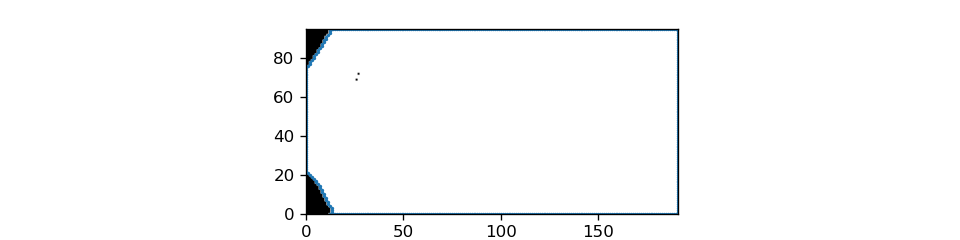

In [8]:
Visualize = True
grey_threshold = 40

cap = cv2.VideoCapture(fname)
    # Name of video file.
thresh_list = []
    
for i in range(0,1):
    ret, img = cap.read()
    if (not ret):
        print("End of file reached!")
        raise StopExecution # gracefully shuts down when end of file is reached
    ret,thresh = cv2.threshold(img,grey_threshold,255,cv2.THRESH_BINARY_INV)
    thresh_list.append(thresh)
    # The next line does a lot, but at its cour it is using the find Contours function to outline contiguous white areas
    contours, hierarchy = cv2.findContours(cv2.cvtColor(thresh,cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    [x,y]=np.transpose(contours[-1]) # This unpacks the points in the largest contour

fig,ax = plt.subplots(figsize = (8,2),dpi=120)
ax.imshow(thresh,origin='upper');
ax.scatter(x,y,s=1);
plt.axis([0, xdim , 0, ydim])

Now, we could manually peruse the list of points in the contour and look for the closest one.  But that would be horribly tedious by hand since there can be thousands of them!

Instead, we'll create a loop finds points in the contour belonging to each 1 pixel vertical slice of the image.  We then find the difference in distance between the top-most and bottom-most ones (this avoids errors due to highlights that can crop ut) and save it.  If it's the smallest one we've found, we update our `thismin` variable.

After getting to the distance `x_max` along the image, the routine saves the smallest neck radius it found and continues with the next frame.  The distance limit is there because the routine sometimes gets confused by light reflecting from the leading edge of the drop.

To visualize this, a red box is drawn over the part that won't be searched over.  We'll also add a line showing where the smallest part of the neck is detected.  Note that it maight jump about a bit in the exact `x` position, but the width usually will vary smoothly

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
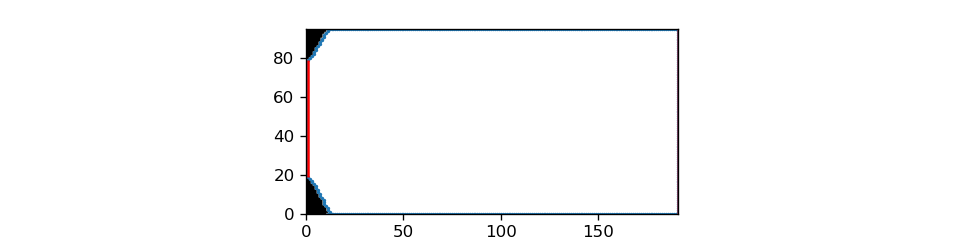

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
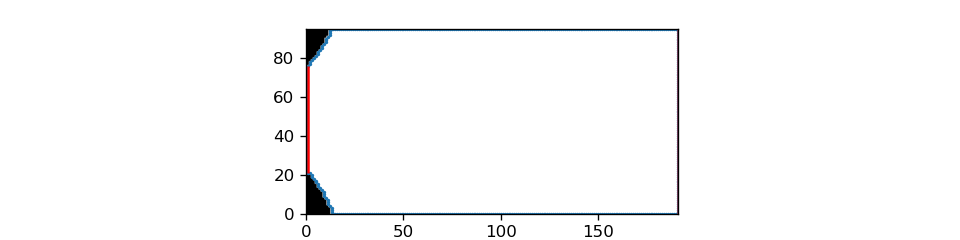

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
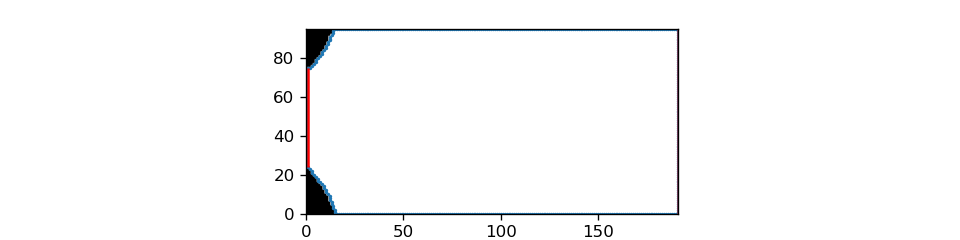

In [9]:
x_max = 600
grey_threshold = 60
# The above variables should be changed to suit your data!

import matplotlib.patches as patches

frames = [] 
neck = []  #Width of neck in pixels
neckposition = []

cap = cv2.VideoCapture(fname)
for i in range(0,3):
    ret, img = cap.read()
    if (not ret):
        print("End of file reached!")
        raise StopExecution # Gracefully shuts down when end of file is reached
    ret,thresh = cv2.threshold(img,grey_threshold,255,cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(cv2.cvtColor(thresh,cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    [x,y]=np.transpose(contours[-1])

    
    dist= []
    radius = ydim;  # Maximum radius is the height of the image
    thismin = ydim;
    thisminposition = 0;  # Position of the minimum for the current frame.
    minpts = [0,ydim]
    for i in range(1,x_max):
        radius = ydim
        matched = np.where(x == i, True,False)
        if(matched.any()):
            radius = max(y[matched])-min(y[matched])
        if(radius< thismin):
            thismin = radius
            thisminposition = i   
            minpts = [min(y[matched]),max(y[matched])]
        dist.append([i,radius])
    neck.append(thismin)
    neckposition.append(thisminposition)  
    fig,ax =  plt.subplots(figsize = (8,2),dpi=120)
    ax.imshow(thresh,origin='upper');
    ax.scatter(x,y,s=1);
    plt.axis([0, xdim , 0, ydim])
    ax.vlines(thisminposition,minpts[0],minpts[1],color='red')
    ax.add_patch(patches.Rectangle(xy=(x_max , 0),width=xdim-x_max , height=ydim,color='red', fill=True,alpha=0.5))
    fig.title = thismin

    

Finally, this next part will go through all the frames (or stop after `max_length`), find the position of the minima, and save the value as `neckposition`.

In [27]:
# THIS IS THE IMPORTANT PART OF THE CODE <-------------------------------- IMPORTANT!
max_length = 300
x_max = 600
grey_threshold = 58  #<- might want to change if you feel another threshold is better

#measurements = []
frames = [] 
neck = []  #Width of neck in pixels
neckposition = []
plt.ioff()
plt.close('all')
progress = widgets.IntProgress(value=0, min=0,max=max_length,description="Progress")
display(progress)
cap = cv2.VideoCapture(fname)
for i in range(0,max_length):
    ret, img = cap.read()
    if (not ret):
        print("End of file reached!")
        raise StopExecution # Gracefully shuts down when end of file is reached
    ret,thresh = cv2.threshold(img,grey_threshold,255,cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(cv2.cvtColor(thresh,cv2.COLOR_BGR2GRAY),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    [x,y]=np.transpose(contours[-1])

    dist= []
    radius = ydim;  # Maximum radius is the height of the image
    thismin = ydim;
    minpts = [0,ydim]
    thisminposition = 0;  # Position of the minimum for the current frame.
    for ix in range(1,x_max):
        radius = ydim
        matched = np.where(x == ix, True,False)
        if(matched.any()):
            radius = max(y[matched])-min(y[matched])
        if(radius < thismin):
            thismin = radius
            minpts = [min(y[matched]),max(y[matched])]
            thisminposition = ix                  
        dist.append([ix,radius])
    neck.append(thismin)
    neckposition.append(thisminposition) #there's a bit of duplication going on in this code, but it works.
    
    global measurements
    if (i != 0):
    #try:  # This will be what normally happens: we just add our data onto the end of a list
        measurements = np.append(measurements,[[i,thismin,minpts[0],minpts[1],thismin]],axis=0)
    #except: # This happens at the first time we record something, since there's no list to add to.
    else:
        measurements = np.array([[i,thismin,minpts[0],minpts[1],thismin]])
        
    gs_font = fm.FontProperties(fname='/System/Library/Fonts/Supplemental/GillSans.ttc')
    plt.style.use('io/inputs/old-style.mplstyle')
    
    fig,ax = plt.subplots(figsize = (10,4),dpi=120)
    ax.imshow(thresh,origin='upper', animated=True);
    ax.scatter(x,y,s=1);
    plt.axis([0, xdim , 0, ydim])
    ax.vlines(thisminposition,minpts[0],minpts[1],color='red')
    ax.add_patch(patches.Rectangle(xy=(x_max , 0),width=xdim-x_max , height=ydim,color='red', fill=True,alpha=0.5))
    
    #ax.set_xlabel(' '.join('TIME (s)'), fontproperties=gs_font, fontsize=14)
    #ax.set_ylabel(' '.join('RADIUS (m)'), fontproperties=gs_font, fontsize=14)
    #ax.set_xlim(3E-5, 1.5E-3)
    #ax.set_ylim(3E-6, 2E-4)
    ax.tick_params('x', which='both', top=True, bottom=True)
    ax.tick_params('y', which='both', right=True, left=True)
    for tick in ax.get_xticklabels():
        tick.set_fontname("Gill Sans")
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontname("Gill Sans")
        tick.set_fontsize(14)   
    
    fig.title = thismin
    frames.append(fig)
    progress.value +=1
plt.ion()        

IntProgress(value=0, description='Progress', max=300)

End of file reached!


In [44]:
fig = frames[57]
fig.savefig('io/outputs/plots/contour57.png', dpi=300)
fig.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
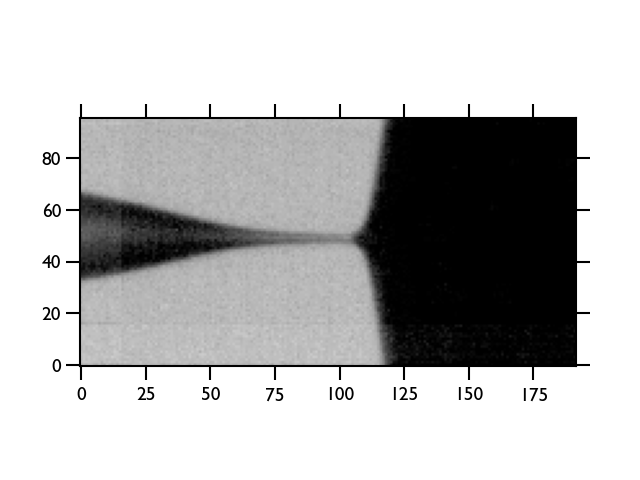

In [63]:
gs_font = fm.FontProperties(fname='/System/Library/Fonts/Supplemental/GillSans.ttc')
plt.style.use('io/inputs/old-style.mplstyle')

fig, ax = plt.subplots()

ax.imshow(np.clip(brightness*img_list[60]/100., 0, 1), origin='lower') 

ax.tick_params('x', which='both', top=True, bottom=True)
ax.tick_params('y', which='both', right=True, left=True)
for tick in ax.get_xticklabels():
    tick.set_fontname("Gill Sans")
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontname("Gill Sans")
    tick.set_fontsize(14)   

fig.savefig('io/outputs/plots/photo60.png', dpi=300)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
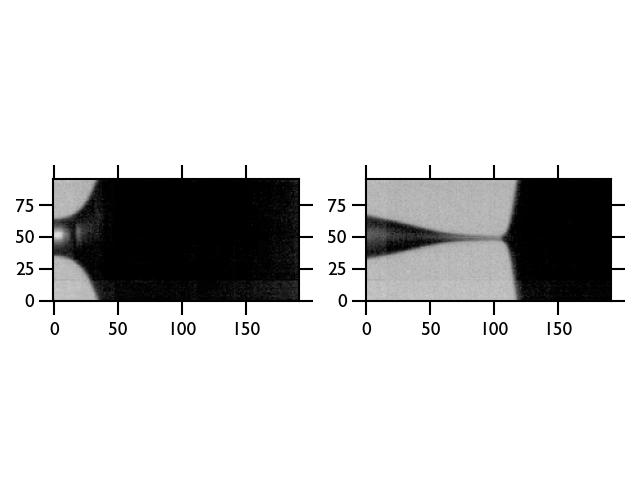

In [57]:
gs_font = fm.FontProperties(fname='/System/Library/Fonts/Supplemental/GillSans.ttc')
plt.style.use('io/inputs/old-style.mplstyle')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=())

ax1.imshow(np.clip(brightness*img_list[12]/100., 0, 1), origin='lower') 

ax1.tick_params('x', which='both', top=True, bottom=True)
ax1.tick_params('y', which='both', right=True, left=True)
for tick in ax1.get_xticklabels():
    tick.set_fontname("Gill Sans")
    tick.set_fontsize(14)
for tick in ax1.get_yticklabels():
    tick.set_fontname("Gill Sans")
    tick.set_fontsize(14)   
    
ax2.imshow(np.clip(brightness*img_list[60]/100., 0, 1), origin='lower') 

ax2.tick_params('x', which='both', top=True, bottom=True)
ax2.tick_params('y', which='both', right=True, left=True)
for tick in ax2.get_xticklabels():
    tick.set_fontname("Gill Sans")
    tick.set_fontsize(14)
for tick in ax2.get_yticklabels():
    tick.set_fontname("Gill Sans")
    tick.set_fontsize(14)   
    
fig.tight_layout()

#fig.savefig('io/outputs/plots/photo57.png', dpi=300)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
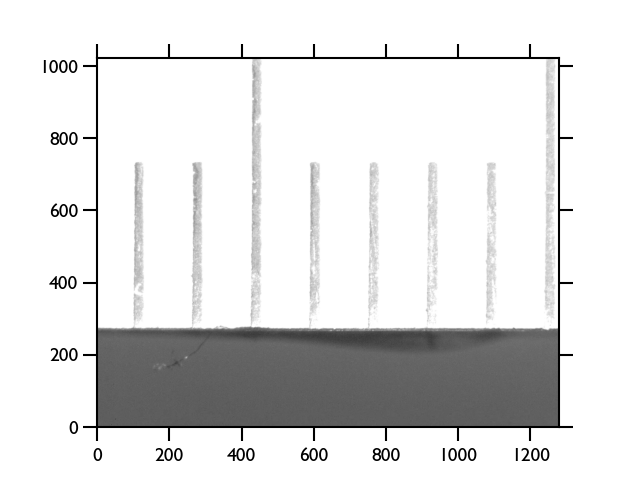

In [49]:
gs_font = fm.FontProperties(fname='/System/Library/Fonts/Supplemental/GillSans.ttc')
plt.style.use('io/inputs/old-style.mplstyle')

fig, ax = plt.subplots()

ax.imshow(np.clip(brightness*img_list_ruler[57]/100., 0, 1), origin='lower') 

ax.tick_params('x', which='both', top=True, bottom=True)
ax.tick_params('y', which='both', right=True, left=True)
for tick in ax.get_xticklabels():
    tick.set_fontname("Gill Sans")
    tick.set_fontsize(14)
for tick in ax.get_yticklabels():
    tick.set_fontname("Gill Sans")
    tick.set_fontsize(14)   

fig.savefig('io/outputs/plots/photo57_ruler.png', dpi=300)

plt.show()

The next bit makes it so you can browse through the data and make sure nothing crazy is going on

In [44]:
# This is where I output the excel sheet. I then imposed some more bounds based on some plotting in the excel sheet.
radii = pd.DataFrame({'frame': measurements[:, 0], 'min': measurements[:, 2], 'max': measurements[:, 3], 'radius': measurements[:, 1]})
t0 = radii.loc[radii['radius'] == 0, 'frame'].min() + 1
fps = 7
radii['time'] = (t0 / fps) - ((radii['frame'] + 1) / fps)
radii = radii.iloc[:t0, [4, 3]]
radii = radii.groupby('radius').mean().reset_index()
radii.to_csv('radii.csv', index=False)

In [11]:
from IPython.display import clear_output
fig, ax = plt.subplots()
disp = widgets.Output()

def showframe(frm=0):
    global frames
    disp.clear_output(wait=True)
    with disp:
        display(frames[frm]);

frame_slider2 = widgets.IntSlider(min=0,max=len(frames)-1,value=0,continuous_update=False) #I got lazy with names, so sue me.
def frame_change2(change): 
    showframe(change['new'])
frame_slider2.observe(frame_change2, names='value')
showframe(0)
display(disp)
display(frame_slider2)

Output()

IntSlider(value=0, continuous_update=False, max=69)

Finally, this plots our data and outputs the positions to a handy .tsv file.

In [ ]:
fig, (ax,ay) = plt.subplots(1,2)
scaletype = "linear"

ax.set_yscale(scaletype)
ax.set_xscale(scaletype)

ax.plot(neckposition,label = "Position",color="b")
ay.plot(neck,label = "Radius")

ax.set_title("Neck position")
ay.set_title("Neck size")


ax.set_ylabel("Pixels")
ax.set_xlabel("Frame")

ay.set_ylabel("Pixels")
ay.set_xlabel("Frame")


plt.tight_layout()
ax.legend()
ay.legend()

 
dat_name = fname[:-1*fname.find(".")] + "_auto_" + str(int(time.time())) + ".tsv"# this cuts off the current suffix and adds the time
toptxt = "Frame \t Radius \t Bottom \t Top \t Position"
np.savetxt(dat_name,measurements[:][sorted_index],header=toptxt) # This sorts your data before saving too!